# Data loading and diffusion

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, DataLoader
import torch
import torchvision.utils as vutils

##Load labelled data from STL10 dataset

In [ ]:

transform = transforms.Compose([
transforms.Resize((32, 32)),             # Resize any image to 96x96
transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10(root='.', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='.', train=False, transform=transform, download=True)
combined_dataset = ConcatDataset([train_dataset, test_dataset])


100%|██████████| 170M/170M [00:06<00:00, 24.6MB/s]


In [ ]:
x, __ = combined_dataset[0]
testing = torch.unsqueeze(x,0)
testing.shape

torch.Size([1, 3, 32, 32])

## Define all values and functions needed to diffuse a image

In [2]:
#Define some diffusion schedule values that will be used in the diffusion forward pass
#These values are computed uaing the cosine schedule
T = 400
s = 0.08
t = torch.linspace(0,T,T+1, device='cuda' if torch.cuda.is_available() else 'cpu')
alpha_t = torch.cos((t/T + s)/(1 + s) * (torch.pi / 2)) ** 2
alpha_t = alpha_t / alpha_t[0]
beta_t = 1 - (alpha_t[1:] / alpha_t[:-1])  # β[1], β[2], ..., β[T]
beta_t = torch.clip(beta_t, 1e-4, 0.999)
beta_t = beta_t.type(torch.float32)
alpha_cumprod = torch.cumprod(1-beta_t,dim=0)

def forward_diff(images, time_steps):
  #This function performs the diffusion of a normal recognizable batch of images and returns the diffused image as well as the noise for training
  #this model uses the cosine schedule
  #time step is used to define the diffusion at certain time steps

  noise = torch.randn_like(images, device=images.device)

  sqrt_alpha = torch.sqrt(alpha_t[time_steps]).view(-1, 1, 1, 1)  # (B, 1, 1, 1)
  sqrt_one_minus_alpha = torch.sqrt(1 - alpha_t[time_steps]).view(-1, 1, 1, 1)

  return (sqrt_alpha*images + sqrt_one_minus_alpha*noise), noise


#Time Embedding

In [ ]:
def get_time_embedding(time_steps, temb_dim):
    """
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula
    :param time_steps: 1D tensor of length batch size
    :param temb_dim: Dimension of the embedding
    :return: BxD embedding representation of B time steps
    """
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"

    factor = 10000 ** ((torch.arange(start=0, end=temb_dim // 2, dtype=torch.float32, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")) / (temb_dim // 2))
    )

    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb

#UNet

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, emb_dim):
    super().__init__()

    self.conv1 = nn.Sequential(nn.GroupNorm(8, in_channels),
                                 nn.SiLU(),
                                 nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))

    self.t_emb_layer = nn.Sequential(nn.SiLU(),
                                     nn.Linear(emb_dim, out_channels))#check this linear
    self.word_emb_layer = nn.Sequential(nn.SiLU(),
                                        nn.Linear(emb_dim, out_channels))

    self.conv2 = nn.Sequential(nn.GroupNorm(8, out_channels),
                                 nn.SiLU(),
                                 nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
    #for adding residual
    self.conv_res = nn.Sequential(nn.GroupNorm(8, in_channels),
                                    nn.SiLU(),
                                    nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1))

  def forward(self,x,t_emb, word_emb):
    output = self.conv1(x)
    output = output + self.t_emb_layer(t_emb).unsqueeze(-1).unsqueeze(-1) + self.word_emb_layer(word_emb).unsqueeze(-1).unsqueeze(-1) #just check embedding and this line
    output = self.conv2(output)
    output = output + self.conv_res(x)
    return output

class AttentionBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.norm = nn.GroupNorm(8, channels)
    self.attention = nn.MultiheadAttention(channels, 4, batch_first=True)

  def forward(self, x):
    batch_size, channels, h, w = x.shape
    in_attn = x.reshape(batch_size, channels, h * w)
    in_attn = self.norm(in_attn)
    in_attn = in_attn.transpose(1, 2)
    out_attn, _ = self.attention(in_attn, in_attn, in_attn)
    out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
    output = x + out_attn #add residual
    return output

class DownBlock(nn.Module):
  #consists of resnetblock attention block and downsample block
  #Return a feature map with halve the height and width and out_channels channels

  def __init__(self, in_channels,out_channels, t_emb_dim):
    super().__init__()
    self.resBlock = ResidualBlock(in_channels, out_channels, t_emb_dim)
    self.Attn = AttentionBlock(out_channels)
    self.downsample = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2,padding=1)

  def forward(self,x,t_emb, word_emb):
    output = self.resBlock(x, t_emb, word_emb)
    output = self.Attn(output)
    downsampled_output = self.downsample(output)
    return output, downsampled_output  #2 resuts one used for skip connection other for assing to next layer

class BottleNeckBlock(nn.Module):
  #consists of resnetblock attention block and another resnet block
  #Return a feature map with the same shape

  def __init__(self, channels, t_emb_dim):
    super().__init__()
    self.resBlock = ResidualBlock(channels, channels, t_emb_dim)
    self.Attn = AttentionBlock(channels)

  def forward(self,x,t_emb, word_emb):
    output = self.resBlock(x, t_emb, word_emb)
    output = self.Attn(output)
    output = self.resBlock(output, t_emb, word_emb)
    return output

class UpBlock(nn.Module):
  #consists of resnetblock attention block and upample block
  #Return a feature map with twice the height and width and out_channels channels

  def __init__(self, in_channels,out_channels, emb_dim):
    super().__init__()
    self.resBlock = ResidualBlock(2*in_channels, out_channels, emb_dim) #2* for skip connection
    self.Attn = AttentionBlock(out_channels)
    self.upsample = nn.ConvTranspose2d(in_channels,in_channels,kernel_size=4,stride=2,padding=1)

  def forward(self,x, skip, t_emb, word_emb):
    output = self.upsample(x)
    assert output.shape[1] == skip.shape[1], "Skip and upsampled channels must match"
    output = torch.cat([output, skip], dim=1)
    output = self.resBlock(output, t_emb, word_emb)
    output = self.Attn(output)
    return output

class UNet(nn.Module):
  def __init__(self, emb_dim, in_channels=3, out_channels=3):
    super().__init__()
    channels = [64,128,256]
    self.emb_dim = emb_dim

    self.first_layer = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)

    self.down1 = DownBlock(32,channels[0], emb_dim)

    self.down2 = DownBlock(channels[0],channels[1], emb_dim)
    self.down3 = DownBlock(channels[1],channels[2], emb_dim)

    self.bottleneck = BottleNeckBlock(channels[2], emb_dim)

    self.up1 = UpBlock(channels[2],channels[1], emb_dim)
    self.up2 = UpBlock(channels[1],channels[0], emb_dim)
    self.up3 = UpBlock(channels[0],channels[0]//2, emb_dim)

    self.final_conv = nn.Sequential(nn.GroupNorm(8, channels[0]//2),
                                    nn.SiLU(),
                                    nn.Conv2d(channels[0]//2, out_channels, kernel_size=3, stride=1, padding=1))

    self.word_emb = nn.Embedding(11,self.emb_dim)


  def forward(self, x, t, label):
    #emb
    t_emb = get_time_embedding(t, self.emb_dim)
    word_emb = self.word_emb(label)

    x= self.first_layer(x)

    skip1, x1 = self.down1(x, t_emb, word_emb)
    skip2, x2 = self.down2(x1,t_emb, word_emb)
    skip3, x3 = self.down3(x2, t_emb, word_emb)

    x4 = self.bottleneck(x3, t_emb, word_emb)

    x5 = self.up1(x4, skip3, t_emb, word_emb)
    x6 = self.up2(x5, skip2, t_emb, word_emb)
    x7 = self.up3(x6, skip1, t_emb, word_emb)

    out = self.final_conv(x7)
    return out

In [5]:
#this code loads a save statedict to reiniialise a trained model
from pathlib import Path
import os
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "Unet.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [ ]:
#gives a top down give of model architecture using torchinfo
model=UNet(24)
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

B = 1
input_image = (B, 3, 32, 32)
time_tensor = torch.tensor([10.0] * B)  # Example time
label_tensor = torch.tensor([1] * B)    # Example label

# You must pass a tuple of example inputs
torchinfo.summary(model, input_data=(torch.randn(input_image), time_tensor, label_tensor))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     --                        --
├─Embedding: 1-1                         [1, 24]                   264
├─Conv2d: 1-2                            [1, 32, 32, 32]           896
├─DownBlock: 1-3                         [1, 64, 32, 32]           --
│    └─ResidualBlock: 2-1                [1, 64, 32, 32]           --
│    │    └─Sequential: 3-1              [1, 64, 32, 32]           18,560
│    │    └─Sequential: 3-2              [1, 64]                   1,600
│    │    └─Sequential: 3-3              [1, 64]                   1,600
│    │    └─Sequential: 3-4              [1, 64, 32, 32]           37,056
│    │    └─Sequential: 3-5              [1, 64, 32, 32]           2,176
│    └─AttentionBlock: 2-2               [1, 64, 32, 32]           --
│    │    └─GroupNorm: 3-6               [1, 64, 1024]             128
│    │    └─MultiheadAttention: 3-7      [1, 1024, 64]           

#Training

In [ ]:
batch_size=96

train_loader = DataLoader(
    combined_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True)

epochs = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(24).to(DEVICE)
if os.path.exists(MODEL_SAVE_PATH):
  model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

for i in range(epochs):
  model.train()
  epoch_loss = 0.0
  count=0

  for (images, labels) in train_loader:
    images = images.to(DEVICE, non_blocking=True)
    labels = labels.to(DEVICE, non_blocking=True)

        # Prepare batch with CFG
    timesteps = torch.randint(0, 400, (images.size(0),), device=DEVICE)
    labels[torch.rand(images.size(0), device=DEVICE) < 0.2] = 10
        # Forward pass
    model_input, target_noise = forward_diff(images, timesteps)

    pred_noise = model(model_input, timesteps, labels)

        # Loss and backward
    loss = criterion(pred_noise, target_noise)
    epoch_loss+=loss
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  print(f"epoch: {i}")
  print(f"epoch loss {epoch_loss/len(train_loader)}")
  if i%2==0:
    torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)
    print("saved")



OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.22 GiB is free. Process 2493 has 13.52 GiB memory in use. Of the allocated memory 11.35 GiB is allocated by PyTorch, and 2.03 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#Inference

In [ ]:
def generate(label, cfg_w=4.5):
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  label = torch.tensor([label],device=DEVICE)

  model = UNet(24).to(DEVICE)
  if os.path.exists(MODEL_SAVE_PATH):
    model.load_state_dict(torch.load(f=MODEL_SAVE_PATH, map_location=torch.device('cpu')))

  model.eval()

  #make random noise image
  T = 400  # Total timesteps
  noisy_image = torch.randn(1, 3, 32, 32, device=DEVICE)  # Start from pure noise

  s = 0.08
  t_vals = torch.linspace(0, T, T + 1, device=DEVICE)
  alpha_t = torch.cos((t_vals / T + s) / (1 + s) * torch.pi / 2) ** 2
  alpha_t = alpha_t / alpha_t[0]
  beta_t = 1 - (alpha_t[1:] / alpha_t[:-1])
  beta_t = torch.clip(beta_t, 1e-4, 0.02)
  alpha_t = 1 - beta_t
  alpha_cumprod = torch.cumprod(alpha_t, dim=0)

  with torch.inference_mode():
    for t in reversed(range(T)):
      t_tensor = torch.tensor([t], device=DEVICE)

      pred_noise_cond = model(noisy_image, t_tensor, label)
      pred_noise_uncond = model(noisy_image, t_tensor, torch.tensor([10], device=DEVICE))

      # Classifier-free guidance
      pred_noise = (pred_noise_uncond + cfg_w * (pred_noise_cond - pred_noise_uncond))

      # DDPM reverse update
      sqrt_recip_alpha_t = 1.0 / torch.sqrt(alpha_t[t])
      sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - alpha_cumprod[t])
      coeff = (1 - alpha_t[t]) / sqrt_one_minus_alpha_cumprod

      noisy_image = sqrt_recip_alpha_t * (noisy_image - coeff * pred_noise)

      if t > 0:
        noise = torch.randn_like(noisy_image)
        noisy_image += torch.sqrt(beta_t[t]) * noise

      #print(noisy_image[0, 0, :, 0])  # optional debug

    # Clamp to valid range
    return torch.clamp(noisy_image, -1, 1)


In [ ]:
  #this function generates an image and converts it to matplotlib readable format before displaying
def show(lable,y):
  x = generate(lable, y)
  image = x.detach().cpu()
  image = image.squeeze(0)
  image = (image + 1) / 2
  image = image.permute(1, 2, 0).numpy()
  plt.figure(figsize=(8, 8))
  plt.imshow(image)
  plt.axis('off')
  plt.show()

models/Unet1 (4) (8).pt


Loading
Finished loading


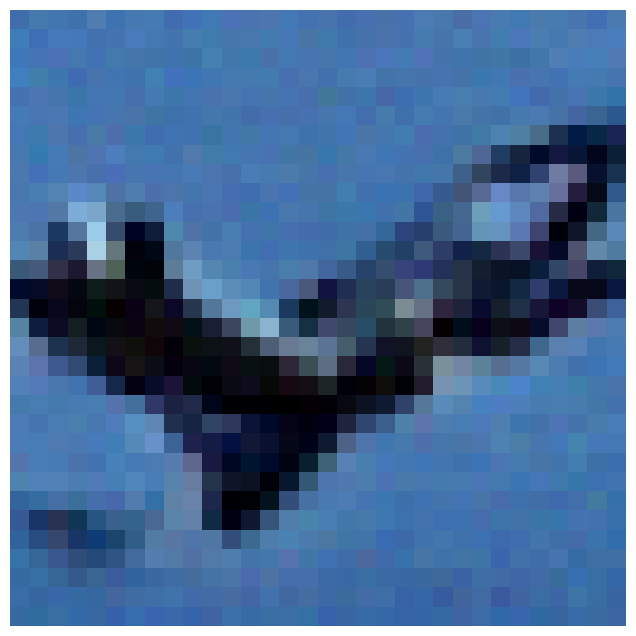

In [ ]:
#example
show(7,4.5)